In [137]:
library(data.table)
library(ggplot2)
library(patchwork)
library(Seurat)

In [138]:
# run data analysis
source('./R/SIM_analysis.R')

## Check data

In [140]:
sim

An object of class Seurat 
1196 features across 8598 samples within 1 assay 
Active assay: TE (1196 features, 1196 variable features)

In [142]:
irescue

An object of class Seurat 
1189 features across 8598 samples within 1 assay 
Active assay: TE (1189 features, 1189 variable features)

In [143]:
scte

An object of class Seurat 
1196 features across 8598 samples within 1 assay 
Active assay: TE (1196 features, 1196 variable features)

## Run correlation tests

In [144]:
md <- rbind(as.data.table(irescue@meta.data, keep.rownames = 'cell'),
            as.data.table(scte@meta.data, keep.rownames = 'cell'),
            as.data.table(sim@meta.data, keep.rownames = 'cell'), fill = T)

In [145]:
nfeature <- dcast(md, cell ~ orig.ident, value.var = 'nFeature_TE')

In [146]:
ncount <- dcast(md, cell ~ orig.ident, value.var = 'nCount_TE')

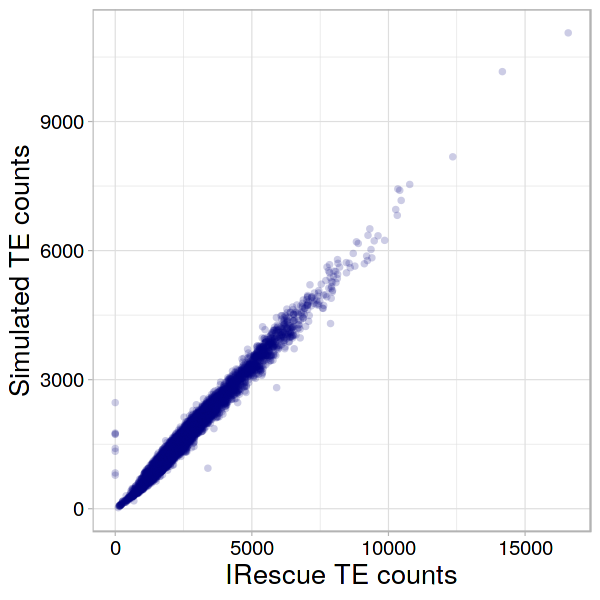

In [292]:
options(repr.plot.width = 5, repr.plot.height = 5)
p_scatter_counts <- ggplot(ncount, aes(irescue, sim)) +
geom_point(shape=16, color = 'navyblue', alpha = .2) +
xlab('IRescue TE counts') +
ylab('Simulated TE counts') +
theme_light() +
theme(axis.title = element_text(size = 16),
      axis.text = element_text(size = 12, colour = 'black'),
      legend.title = element_blank(),
      legend.text = element_text(size = 14, colour = 'black'))
p_scatter_counts

In [63]:
cor.test(ncount$irescue, ncount$sim, method = 'spearman')

Warning message in cor.test.default(ncount$irescue, ncount$sim, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  ncount$irescue and ncount$sim
S = 2470907774, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9766753 


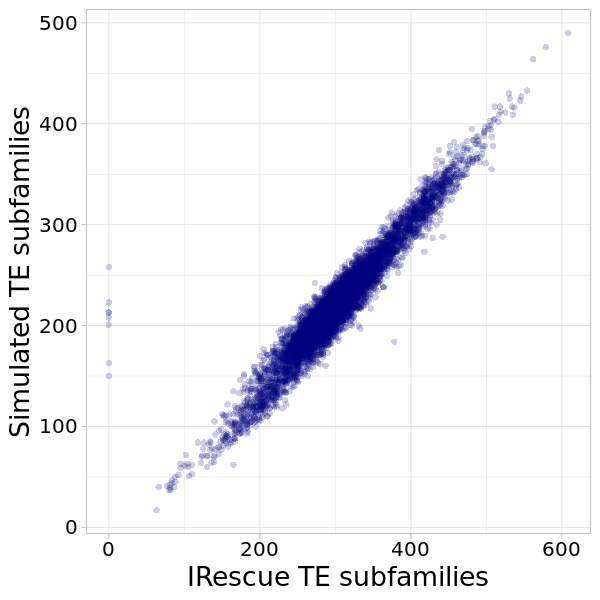

In [50]:
options(repr.plot.width = 5, repr.plot.height = 5)
p_scatter_features <- ggplot(nfeature, aes(irescue, sim)) +
geom_point(shape=16, color = 'navyblue', alpha = .2) +
xlab('IRescue TE subfamilies') +
ylab('Simulated TE subfamilies') +
theme_light() +
theme(axis.title = element_text(size = 16),
      axis.text = element_text(size = 12, colour = 'black'),
      legend.title = element_blank(),
      legend.text = element_text(size = 14, colour = 'black'))
p_scatter_features

In [62]:
cor.test(nfeature$irescue, nfeature$sim, method = 'spearman')

Warning message in cor.test.default(nfeature$irescue, nfeature$sim, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  nfeature$irescue and nfeature$sim
S = 5980559127, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9435452 


In [33]:
counts <- rbindlist(list(
    'sim'     = melt(as.data.table(as.matrix(GetAssayData(sim, slot = 'counts')), keep.rownames = 'te'),
                     id.vars = 'te', value.name = 'count', variable.name = 'cell'),
    'irescue' = melt(as.data.table(as.matrix(GetAssayData(irescue, slot = 'counts')), keep.rownames = 'te'),
                     id.vars = 'te', value.name = 'count', variable.name = 'cell'),
    'scte'    = melt(as.data.table(as.matrix(GetAssayData(scte, slot = 'counts')), keep.rownames = 'te'),
                     id.vars = 'te', value.name = 'count', variable.name = 'cell')
), use.names = TRUE, idcol = 'method')

In [34]:
dcounts <- dcast(counts, te+cell~method, value.var = 'count', fill = 0)

In [184]:
cor.test(dcounts$sim, dcounts$irescue, method = 'spearman')

Warning message in cor.test.default(dcounts$sim, dcounts$irescue, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  dcounts$sim and dcounts$irescue
S = 3.4038e+19, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8064149 


In [185]:
cor.test(dcounts$sim, dcounts$scte, method = 'spearman')

Warning message in cor.test.default(dcounts$sim, dcounts$scte, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  dcounts$sim and dcounts$scte
S = 4.0159e+19, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.771607 


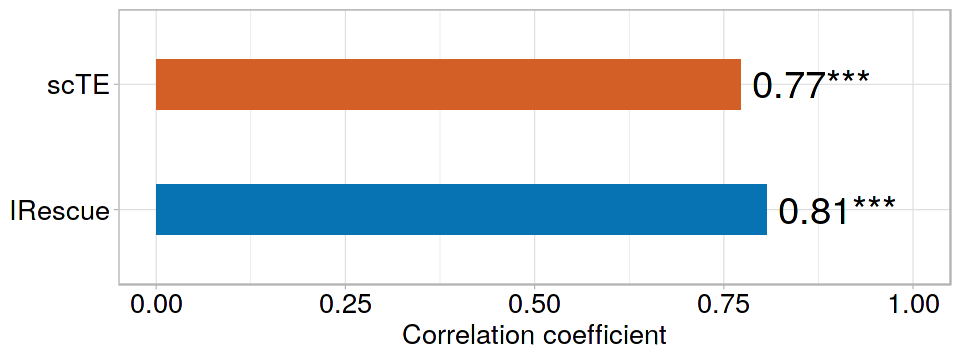

In [294]:
iRsize(8,3)
p_corr <- data.frame('R' = c(0.771607, 0.8064149), 'Method' = c('scTE', 'IRescue')) |>
ggplot(aes(Method, R, fill = Method)) +
geom_col(width = .4) +
geom_text(aes(label = paste0(round(R, 2), '***')), size = 8, hjust = -0.1) +
coord_flip() +
ylim(0,1) +
ylab('Correlation coefficient') +
scale_fill_manual(values = c('#0773B2', '#D35F27')) +
theme_light() +
theme(#axis.ticks = element_line(colour = 'black'),
      axis.title.y = element_blank(),
      axis.title.x = element_text(size = 16),
      axis.text = element_text(size = 16, colour = 'black'),
      legend.position = 'none')
p_corr

In [37]:
dcounts[, irescue_reldev := (irescue-sim)/max(irescue,sim,na.rm = T)]
dcounts[is.na(irescue_reldev), irescue_reldev := 0]
dcounts[, scte_reldev := (scte-sim)/max(scte,sim,na.rm = T)]
dcounts[is.na(scte_reldev), scte_reldev := 0]

In [38]:
dev <- melt(dcounts, id.vars = c('te','cell'),
            measure.vars = c('irescue_reldev','scte_reldev'), variable.name = 'method', value.name = 'reldev')
dev[, method := sub('_reldev','',method)]

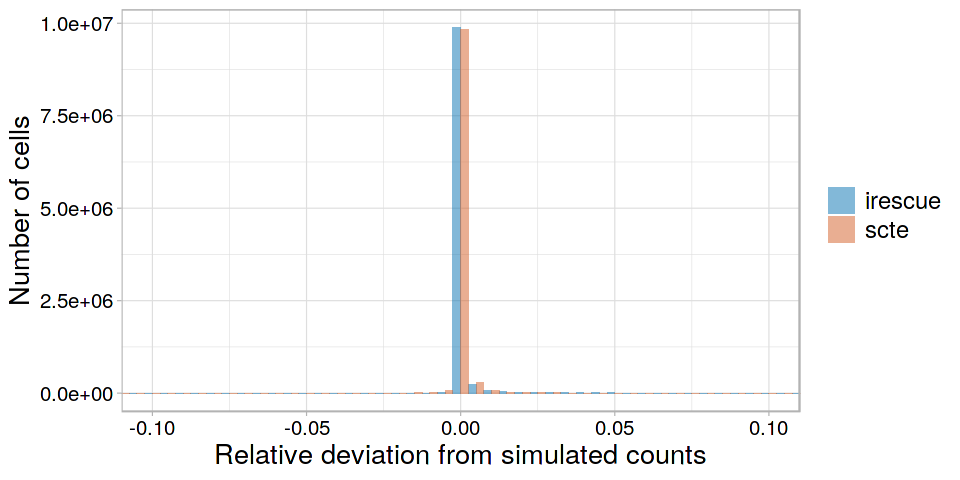

In [301]:
options(repr.plot.width = 8, repr.plot.height = 4)
p_devhist <- ggplot(dev, aes(reldev, fill = method)) +
geom_histogram(binwidth = .005, position = 'dodge', alpha = .5, color = NA) +
coord_cartesian(xlim = c(-0.1,0.1)) +
scale_color_manual(values = c('#0773B2','#D35F27')) +
scale_fill_manual(values = c('#0773B2','#D35F27')) +
ylab('Number of cells') +
xlab('Relative deviation from simulated counts') +
theme_light() +
theme(axis.title = element_text(size = 16), axis.text = element_text(size = 12, colour = 'black'),
      legend.title = element_blank(), legend.text = element_text(size = 14, colour = 'black'))
p_devhist

In [42]:
dcounts[, irescue_r := cor(irescue, sim, method = 'spearman'), cell]
dcounts[, scte_r := cor(scte, sim, method = 'spearman'), cell]
percell <- melt(dcounts, id.vars = c('te','cell'), measure.vars = c('irescue_r','scte_r'), variable.name = 'method', value.name = 'r')
percell[, method := sub('_r','',method)]

Warning message in cor(irescue, sim, method = "spearman"):
“the standard deviation is zero”
Warning message in cor(irescue, sim, method = "spearman"):
“the standard deviation is zero”
Warning message in cor(irescue, sim, method = "spearman"):
“the standard deviation is zero”
Warning message in cor(irescue, sim, method = "spearman"):
“the standard deviation is zero”
Warning message in cor(irescue, sim, method = "spearman"):
“the standard deviation is zero”
Warning message in cor(irescue, sim, method = "spearman"):
“the standard deviation is zero”
Warning message in cor(irescue, sim, method = "spearman"):
“the standard deviation is zero”
Warning message in cor(irescue, sim, method = "spearman"):
“the standard deviation is zero”


Warning message:
“Removed 22819 rows containing non-finite values (stat_ecdf).”


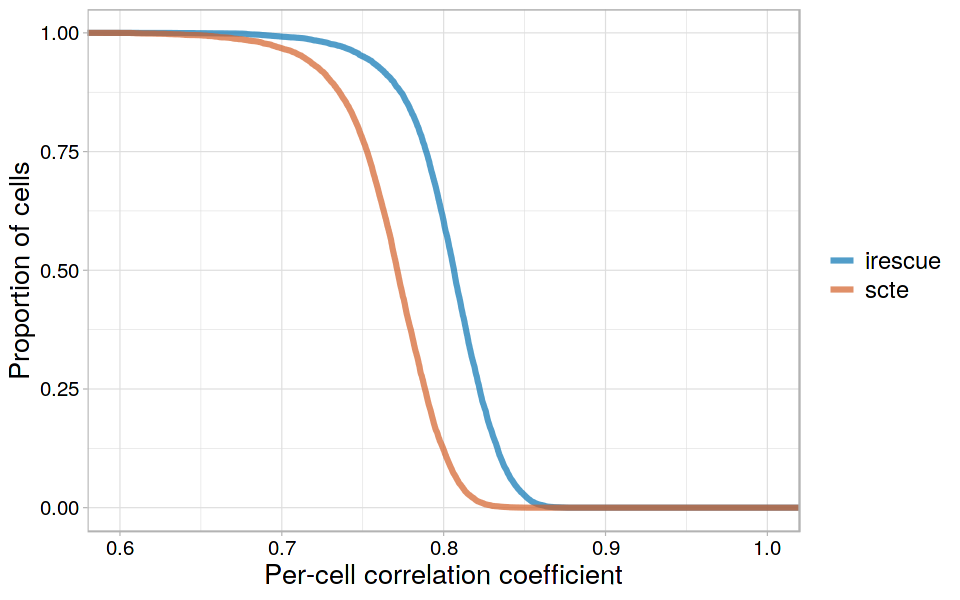

In [328]:
iRsize()
p_cellcorr <- ggplot(percell, aes(r, color = method)) +
geom_line(aes(y = 1 - ..y..), stat='ecdf', size = 1.3, alpha = .7) +
scale_color_manual(values = c('#0773B2','#D35F27')) +
xlim(0.6,1) +
ylab('Proportion of cells') +
xlab('Per-cell correlation coefficient') +
theme_light() +
theme(axis.title = element_text(size = 16), axis.text = element_text(size = 12, colour = 'black'),
      legend.title = element_blank(), legend.text = element_text(size = 14, colour = 'black'))
p_cellcorr

In [47]:
percell[, .('mean_corr' = mean(r, na.rm = T), 'median_corr' = median(r, na.rm = T)), method]

method,mean_corr,median_corr
<chr>,<dbl>,<dbl>
irescue,0.8032317,0.8063827
scte,0.7676132,0.7713446


## Cluster correlation analysis

Warning message in chisq.test(table(clusters[, .(irescue, sim)])):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  table(clusters[, .(irescue, sim)])
X-squared = 37722, df = 64, p-value < 2.2e-16


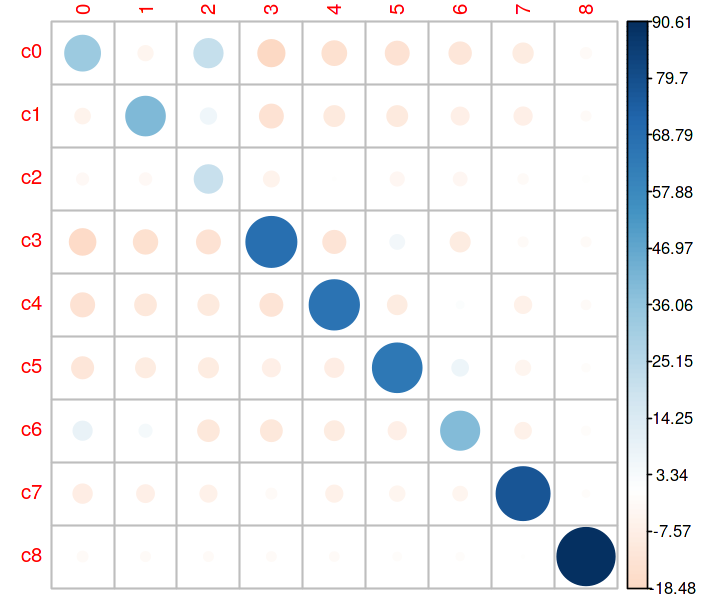

In [475]:
X <- chisq.test(table(clusters[, .(irescue,sim)]))
X
corrplot::corrplot(X$residuals, is.cor = FALSE)

Warning message in chisq.test(table(clusters[, .(scte, sim)])):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  table(clusters[, .(scte, sim)])
X-squared = 35699, df = 64, p-value < 2.2e-16


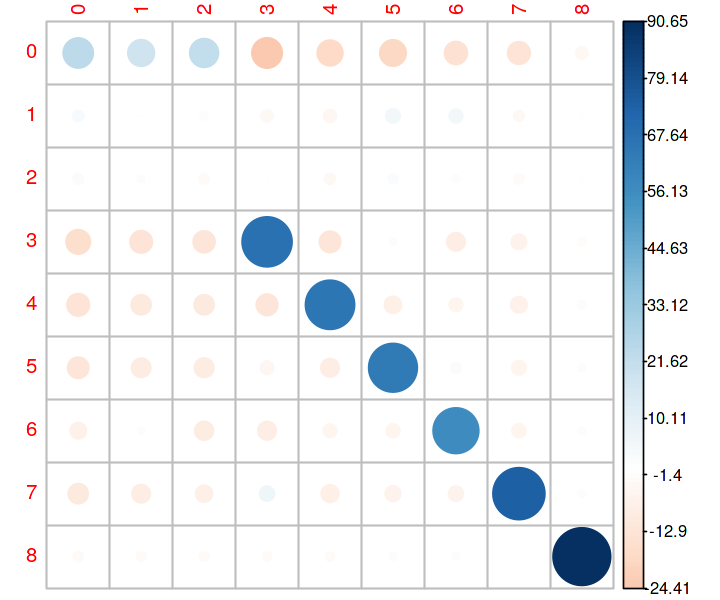

In [483]:
X <- chisq.test(table(clusters[, .(scte,sim)]))
X
corrplot::corrplot(X$residuals, is.cor = FALSE)

## UMI count

In [556]:
# total umi
tot <- 70941233

In [558]:
# percentage of TE-associated UMIs
umi[, uniqueN(umi)] / tot

[1] 0.3259198

In [132]:
print(umicount)

         n                          cat perc      mil percent
1: 4864234              Uniquely mapped   21 4.864234     21%
2: 9124816  Multi-mapped intra-subfamly   39 9.124816     39%
3: 9132099 Multi-mapped inter-subfamily   39 9.132099     39%


In [129]:
# Exact proportion
prop.table(df$n)

[1] 0.2103803 0.3946524 0.3949674

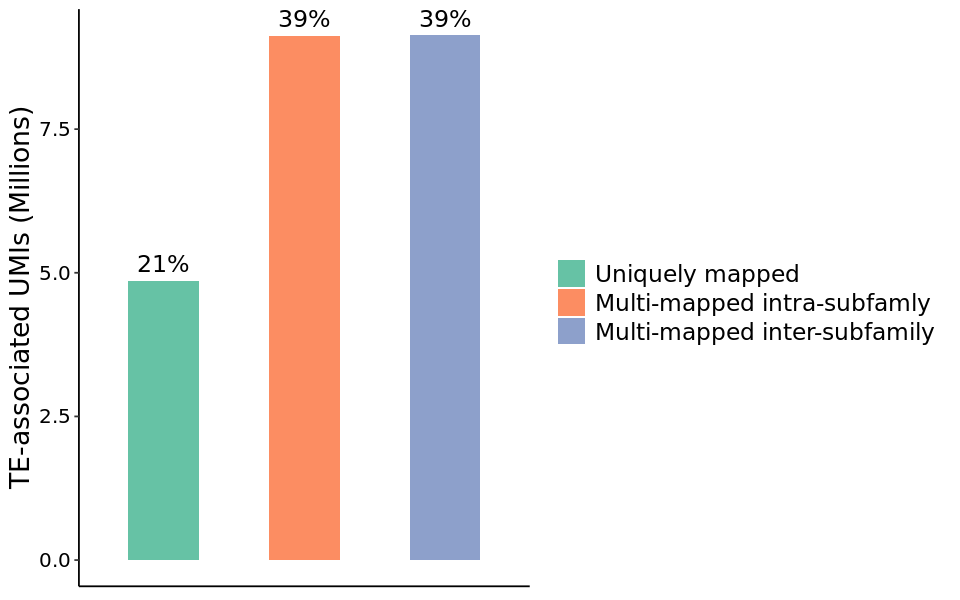

In [130]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(df, aes(cat, mil, fill = cat)) +
geom_col(width = .5) +
geom_text(aes(label = percent), vjust = -0.5, size = 5) +
ylab('TE-associated UMIs (Millions)') +
scale_fill_manual(values = RColorBrewer::brewer.pal(3, 'Set2')) +
theme_classic() +
theme(axis.title.x = element_blank(),
      axis.title.y = element_text(size = 16),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      axis.text.y = element_text(size = 12, colour = 'black'),
      legend.title = element_blank(), legend.text = element_text(size = 14, colour = 'black'))

NB: the percentage closer to the next integer digit will be rounded up to correct the approximation error and make the sum equal to 100%

In [576]:
head(ec)

cell,umi,ec_tes,ec,umis_by_ec_cell
<chr>,<chr>,<int>,<chr>,<int>
AAACCTGAGCATCATC,AAACCTGAGCATCATC_AAAAAACTCG,2,AluJr~Alu/SINE|L1M5~L1/LINE,2
AAACCTGAGCATCATC,AAACCTGAGCATCATC_AAAAACGTTT,1,L1MC4a~L1/LINE,4
AAACCTGAGCATCATC,AAACCTGAGCATCATC_AAAAATTGCC,1,AluSp~Alu/SINE,46
AAACCTGAGCATCATC,AAACCTGAGCATCATC_AAAACACACT,1,MIRc~MIR/SINE,8
AAACCTGAGCATCATC,AAACCTGAGCATCATC_AAAACCACTG,1,AluSx4~Alu/SINE,14
AAACCTGAGCATCATC,AAACCTGAGCATCATC_AAAACCCCCT,1,AluJo~Alu/SINE,62


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



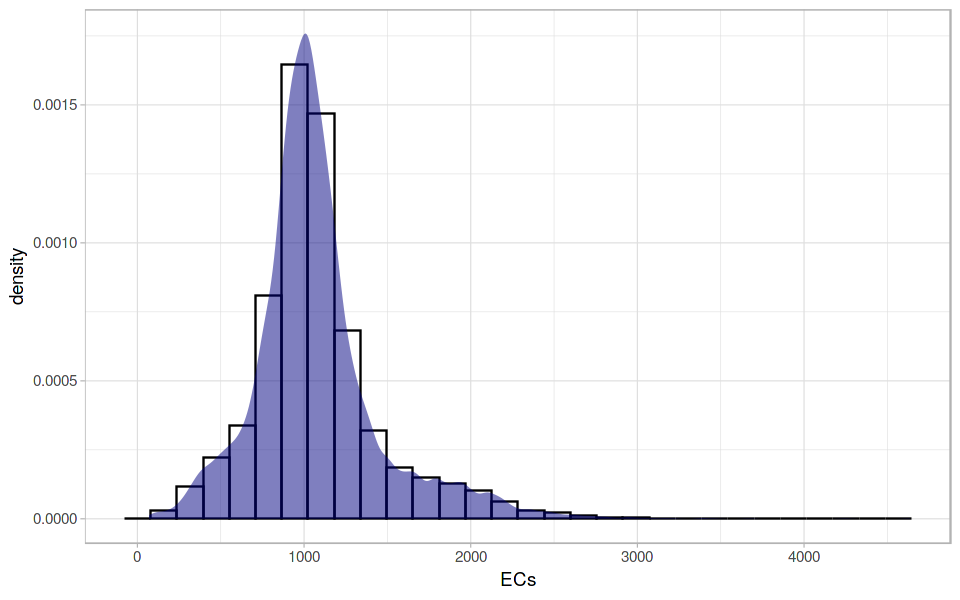

In [579]:
# equivalence classes by cell
options(repr.plot.width = 8, repr.plot.height = 5)
ec[, .(ECs = uniqueN(ec)), cell] %>% 
ggplot(aes(ECs)) +
geom_histogram(aes(y=..density..), fill = NA, color = 'black') +
geom_density(fill = 'navyblue', alpha = .5, color = NA) +
theme_light()

In [582]:
summary(ec[, .(ECs = uniqueN(ec)), cell]$EC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     70     874    1024    1078    1202    4636 

In [595]:
summary(cells_by_ec$ec_tes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   4.000   5.134   6.000  50.000 

In [583]:
cells_by_ec <- ec[, .(cells = uniqueN(cell)), .(ec,ec_tes)]

In [601]:
quantile(cells_by_ec$ec_tes, probs = .9)

90% 
  8

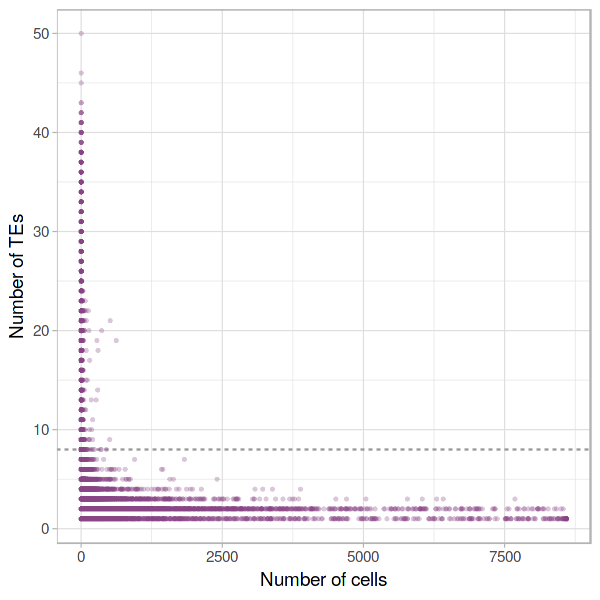

In [604]:
# equivalence classes by cell
iRsize(5,5)
ggplot(cells_by_ec, aes(cells, ec_tes)) +
geom_hline(yintercept = quantile(cells_by_ec$ec_tes, probs = .9), linetype = 'dashed', color = 'gray60') +
geom_point(size = 1, color = 'orchid4', alpha = .3, shape = 16) +
xlab('Number of cells') +
ylab('Number of TEs') +
theme_light()